In [1]:
# from skbio.diversity import alpha_diversity
# adiv_obs_otus = alpha_diversity('observed_otus', data, ids)
# adiv_obs_otus


In [25]:
import sys
import os
sys.path.insert(0,'/global/homes/b/bpb/repos/blink/lbnl_tools/ToM_Diversity/')
# sys.path.insert(0,'/global/homes/b/bpb/repos/blink/lbnl_tools/ToM_Diversity/')
import blink_diversity

sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.untargeted import tools as mzm

import matplotlib.pyplot as plt

In [2]:
# from importlib import reload  # Python 3.4+
# reload(blink_diversity)

In [3]:
import pandas as pd
md = blink_diversity.metabolite_diversity()
# comparisons = pd.read_pickle(md.params.berklab_mcs_filename)
# comparisons.head()

In [4]:
%%time
md = blink_diversity.metabolite_diversity()
# md.polarity = 'Positive'
md.get_treecompound_metadata()
md.make_linkage_from_mcs_matrix()
md.make_skbio_tree()
# md.get_berklab_ref()

/global/common/software/m2650/python3-matchms/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/global/homes/b/bpb/repos/blink/lbnl_tools/ToM_Diversity/blink_diversity.py:35: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  z = linkage(n,method='single')


CPU times: user 16.1 s, sys: 502 ms, total: 16.6 s
Wall time: 16.7 s


In [60]:
sql = """SELECT Key, feature_key.experiment, feature_key.polarity, sharedpeaks,score, massdiff, inchikey FROM gnps_hits
WHERE score>0.7 AND sharedpeaks>3 AND UPPER(feature_key.experiment) LIKE UPPER('%frtlzr%');"""
    
hits = mzm.api.query.execute_sql('lists', sql,max_rows=int(1e9))
hits = pd.DataFrame(hits['rows'])
        

In [61]:
hits

,score,inchikey,experiment,massdiff,sharedpeaks,_labkeyurl_inchikey,Key,polarity
0,0.976765,OIRDTQYFTABQOQ-KQYNXXCUSA-N,20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-13...,0.000092,7.0,/LIMS/list-details.view?name=gnps_compounds&pk...,1477642,positive
1,0.975945,OIRDTQYFTABQOQ-UHFFFAOYSA-N,20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-13...,0.004089,7.0,/LIMS/list-details.view?name=gnps_compounds&pk...,1477643,positive
2,0.721017,FYGUSUBEMUKACF-UHFFFAOYSA-N,20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-13...,0.000099,4.0,/LIMS/list-details.view?name=gnps_compounds&pk...,1477652,positive
3,0.957533,JJMDCOVWQOJGCB-UHFFFAOYSA-N,20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-13...,0.003304,4.0,/LIMS/list-details.view?name=gnps_compounds&pk...,1477654,positive
4,0.946000,JJMDCOVWQOJGCB-UHFFFAOYSA-N,20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-13...,0.000107,5.0,/LIMS/list-details.view?name=gnps_compounds&pk...,1477655,positive
...,...,...,...,...,...,...,...,...
19341,0.992952,KMYWVDDIPVNLME-UHFFFAOYSA-N,20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_ID...,0.006012,5.0,/LIMS/list-details.view?name=gnps_compounds&pk...,2010443,negative
19342,0.992309,FPUGCISOLXNPPC-UHFFFAOYSA-N,20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_ID...,0.006012,5.0,/LIMS/list-details.view?name=gnps_compounds&pk...,2010444,negative
19343,0.990573,GFFGJBXGBJISGV-UHFFFAOYSA-N,20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_ID...,0.006210,5.0,/LIMS/list-details.view?name=gnps_compounds&pk...,2010445,negative
19344,0.984040,LMXOHSDXUQEUSF-UHFFFAOYSA-N,20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_ID...,0.006012,5.0,/LIMS/list-details.view?name=gnps_compounds&pk...,2010446,negative


In [62]:
def calc_diversity(hits):
    temp = pd.DataFrame()
    temp['node_ids'] = md.node_ids
    df = pd.merge(temp,hits.sort_values('score',ascending=False).drop_duplicates('inchikey'),left_on='node_ids',right_on='inchikey',how='left')
    df['present'] = pd.notna(df['score'])
    idx = df['present']==True
    df.loc[idx,'present'] = 1
    idx = df['present']==False
    df.loc[idx,'present'] = 0
    md.num_unique_inchikey_hits_in_network = df.shape[0]
    md.hits = df
    md.pd_diversity_file()
    return md.pd_diversity

global_div = calc_diversity(hits)
global_div

325.5291491394378

In [63]:
div_df = hits.groupby(['experiment','polarity']).apply(calc_diversity)
div_df = pd.DataFrame(div_df,columns=['diversity'])
# div_df.columns = [['diversity']]
div_df

diversity
experiment                                         polarity            
20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-139... negative   87.406785
                                                   positive   97.939387
20210813_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-HF_... negative   49.621309
                                                   positive  112.071828
20210831_JGI-AK_PA-CT_507784_Frtlzr_Set1-100to1... negative   54.075007
                                                   positive  117.553170
20211109_JGI-AK-TH_PA-CT_507784_Frtlzr_Pt4_QE-1... negative    7.903963
                                                   positive   16.274281
20211111_JGI-AK-TH_PA-CT_507784_Frtlzr_Scn-AgS_... positive   37.935341
20211111_JGI-AK-TH_PA-CT_507784_Frtlzr_Scn-AgS_... positive   37.935341
20211206_JGI-AK-TH_PA-CT_507784_Frtlzr_Scn-AgS_... negative   23.581365
20211217_JGI-TH_PA_507784_Frtlzr_Soil_IDX_HILIC... negative   22.829590
                                                   positive   37.767679
20220204_JGI-TH_PA_507784_Frtlzr_PlantMB_QE-HF_... negative   26.295596
                                                   positive   58.161142
20220303_JGI-TH_PA_507784_Frtlzr_SoilSD_QE-HF_H... negative   17.557476
                                                   positive   34.162472
20220321_JGI-TH_PA_507784_Frtlzr_SoilSD_IDX_C18... negative    9.655047
                                                   positive   35.330235
20220414_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   58.239424
                                                   positive   60.625542
20220415_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   80.273900
                                                   positive   75.285142
20220418_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   46.861480
                                                   positive   50.192513
20220506_JGI-TH_PA_507784_Frtlzr_SoilSD_QE-HF_H... negative   17.182881
                                                   positive   29.599713
20220606_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   79.626144
                                                   positive   85.864021
20220613_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   20.335701
                                                   positive   31.178546
20220712_JGI_PA-CT_507784_Frtlzr_CultFinal1_QE-... negative    6.068047
                                                   positive   11.302485
20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_IDX... negative   40.086430
                                                   positive   64.462247

<AxesSubplot:>

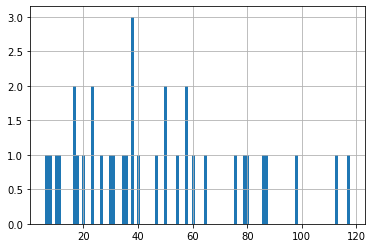

In [64]:
fig,ax = plt.subplots()
div_df['diversity'].hist(ax=ax,bins=100)

In [65]:
div_df.sort_values('diversity',ascending=False,inplace=True)
div_df.head(20)

diversity
experiment                                         polarity            
20210831_JGI-AK_PA-CT_507784_Frtlzr_Set1-100to1... positive  117.553170
20210813_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-HF_... positive  112.071828
20210804_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-139... positive   97.939387
                                                   negative   87.406785
20220606_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... positive   85.864021
20220415_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   80.273900
20220606_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   79.626144
20220415_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... positive   75.285142
20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_IDX... positive   64.462247
20220414_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... positive   60.625542
                                                   negative   58.239424
20220204_JGI-TH_PA_507784_Frtlzr_PlantMB_QE-HF_... positive   58.161142
20210831_JGI-AK_PA-CT_507784_Frtlzr_Set1-100to1... negative   54.075007
20220418_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... positive   50.192513
20210813_JGI-AK_PA-CT_507784_Frtlzr_Set1_QE-HF_... negative   49.621309
20220418_JGI-TH_PA_507784_Frtlzr_10S-Feedstock_... negative   46.861480
20220715_JGI_PA-CT_507784_Frtlzr_CultFinal1_IDX... negative   40.086430
20211111_JGI-AK-TH_PA-CT_507784_Frtlzr_Scn-AgS_... positive   37.935341
20211111_JGI-AK-TH_PA-CT_507784_Frtlzr_Scn-AgS_... positive   37.935341
20211217_JGI-TH_PA_507784_Frtlzr_Soil_IDX_HILIC... positive   37.767679

In [55]:
df = pd.pivot_table(hits,index='inchikey',columns=['experiment'],values='score')
df

experiment,20180122_SK_JS_Ecofab_Ringtrial_Nov2017-rt-exud_QE119_50454_738383,20180129_SK_JS_EcoFAB_Ringtrial_Nov2017-rts_QE119_50454_738390,20180203_SK_JS_EcoFAB_Ringtrial_Nov2017-rt-exud_QE144_EPC18_USDAY34878,20180205_SK_JS_EcoFAB_Ringtrial_Nov2017-rts_QE144_EPC18_USDAY34878,20180206_SK_JS_EcoFAB_Ringtrial_Nov2017-shts_QE144_EPC18_USDAY34878,20180314_KBL_AK_C18_ENIGMA_SoilEx,20180320_KBL_C18Lipid_IG_algae_round1,20180320_KBL_IG_BETO_Lipid_Scenedesmus,20180330_KBL_TF_CC_Nectar_Mreuk_Pilot,20180406_KBL_MW_JS_C18Lipid_LS_Pilot,...,20220826_EB_YZ_107432-001_Screen1234_20220801_QE119_HILICZ_USHXG01900,20220826_EB_YZ_107432-001_Screen12_20220801_QE119_HILICZ_USHXG01900,20220826_JGI_KD_507977_AgarExp2_pilot2_EXP120B_C18_USDAY63649,20220906_JGI_GD_508102_Microcystis_pilot_QEHF_HILICZ_USHXG01885,20220907_EB_YD_107002-011_Diurnal_20220518ConcTes_QE119_HILICZ_USHXG01900,20220909_JGI_GD_508102_Microcystis_pilot_IDX_HILICZ_USHXG01824,20220915_EB_YD_107002-011_Diurnal_20220518AllConc_QE119_HILICZ_USHXG01900,20220922_EB_YD_107002-011_Diurnal_20220518AllConc_QE119_C18-EP_USDAY59441,Without_inj_volume,mzml
inchikey,,,,,,,,,,,,,,,,,,,,,
AADVZSXPNRLYLV-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGCATAPYOEULE-LHHMAMHXSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGFPTSOPGCENQ-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAKDPDFZMNYDLR-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAWZDTNXLSGCEK-LNVDRNJUSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.929027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.863113,0.907786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZWPMFROUHHAKY-OUUKCGNVSA-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZZWPMFROUHHAKY-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.799084,NaN
ZZWPMFROUHHAKY-UHFFFAOYSA-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.811900,NaN
